# CS-E4895: Gaussian Processes

## Assignment #4: Variational inference for GP classification

### Learning objectives

After completing the exercise, you should be able to:

- Implement variational inference for GP classification and hyperparameter selection.
- Know how to apply an automatic differentiation framework, such as Tensorflow, in the GP context.

### Important Notes

- In the first part of this assignment, we will use an automatic differentiation framework to optimize the ELBO objective that arises in variational inference. Most standard optimization methods require access to the gradients of the optimized function. If you were able to derive them by hand for this particular task, you could optimize using standard numpy/scipy. Nowadays, however, these automatic differentiation frameworks make things quite a lot easier, providing easy gradients and integrating them with different standard optimizers. This assignment is designed with Tensorflow, but if you wish, you can try implementing everything with a different framework, such as Pytorch or Jax (we suggest to stick with Tensorflow unless you feel sure about yourself). 
- All exercises must be solved using only basic mathematical operations (exp, erf, ...) and linear algebra routines (solve, matrix-vector products, ...)
- Common gotcha: getting the shape of your arrays wrong e.g. (N, 1) vs (1, N) vs (N,); check that all your functions get and return arrays of the correct shapes!

## Enter your student number

**STUDENT_NUMBER** = 103198246

## Warnings:

- Don’t copy and paste cells within a notebook. This will mess up the tracking metadata and prevent autograding from working.
- Only add new cells using the '+' button in the upper toolbar, and do not split cells.
- Be cautious about things such as copying the whole notebook to Colab to work on it. This has sometimes resulted in removing all notebook metadata, making autograding impossible.

### Do not move or delete the below block. It is used for automatic grading.

In [188]:
%matplotlib inline
import os
import numpy as np
import math
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import csv

In [160]:
automatic_grading = True  # Set this to True after completing the notebook and before submitting.

### Do not move or delete the below block. It is used for automatic grading.

### A mini tutorial on automatic differentiation

When using an automatic differentiation framework to optimize a function $f: \theta \to f(\theta)$, the variable $\theta$ and/or the operations mapping from $\theta$ to $f(\theta)$ must be defined using operators from the framework.

For example to optimize $e^{\theta}+e^{-\theta}$ with respect to $\theta$ with TensorFlow, you need to proceed as follows: (See tutorial on gradient calculation in TensorFlow: https://www.tensorflow.org/api_docs/python/tf/GradientTape)

In [189]:
# define the theta variable
theta = tf.Variable(1.0, dtype=tf.float64)

# define the function
f = lambda x: tf.exp(x) + tf.exp(-x) # note the use of the tf.exp operation (not np.exp)

# run the optimization
for t in range(1000):
    # at each step, compute the gradients
    with tf.GradientTape() as tape:
        tape.watch(theta)
        loss = f(theta)
    
    gradient = tape.gradient(loss, theta)
    
    # apply the variable update (gradient descent)
    theta.assign(theta - 0.01*gradient)
    
    if t % 100 == 0:
        print(t, theta)

0 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.976495976127124>
100 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.11997260765615987>
200 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.01589141680262445>
300 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.00210746772964796>
400 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.0002794913296214945>
500 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.7066015766512994e-05>
600 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.91567854916927e-06>
700 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=6.519151061083718e-07>
800 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=8.645669185832985e-08>
900 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.1465848082505852e-08>


### Task 1: ELBO components (3 points)

We are interested in the problem of Gaussian Process classification. We have some data $\mathcal{D} = \left\lbrace {\bf x}_n, y_n \right\rbrace_{n=1}^N$, with $y_n \in \{-1,1\}$.

We want to perform inference in the following generative model:
$$
\begin{align*}
f(\cdot) &\sim GP(0, k) \\
f_n &= f({\bf x}_n) \qquad &&(f_n\in \mathbb{R}) \\
\theta_n &= \phi(f_n) \qquad &&(\theta_n\in (0, 1)) \\
\{-1,1\} \ni y_n  &\sim \text{Bernoulli}(p=\theta_n)
\end{align*}
$$
with $\phi$ the normal cumulative distribution function $\phi(x)=\int_{-\infty}^x {\cal N}(u; 0,1)\,{\rm d}u$.

We can compactly write the likelihood as
$$ p(y_n|f(\cdot),{\bf x}_n) = p(y_n|f_n) = \phi(y_n \cdot f_n).$$


We will here use a Squared Exponential kernel, with two parameters: lengthscale $\ell$ and variance $\sigma^2$.


The posterior is $p({\bf f}|{\bf y}) \propto p({\bf y}\mid{\bf f})p({\bf f})$ is intractable, hence we resort to an approximate inference scheme called **variational inference**.

This turns inference into optimization. We optimize the distance $d(q) = \operatorname{KL}[q({\bf f})\|p({\bf f}|{\bf y})] \geq 0$, with respect to a distribution $q({\bf f})$.

We parameterize $q$ through the mean vector $m$ and the Cholesky factor of the covariance $L$: i.e. $q({\bf f})={\cal N}({\bf f}\mid \bf{m}, \bf{S}=\bf{L}\bf{L}^\top)$

In practice we optimize the ELBO:
$${\cal L}(q) = \log p({\bf y})-d(q) = 
\underbrace{\mathbb{E}_q\big[ \log p({\bf y}|{\bf f}) \big]}_{\text{VE}} 
- \underbrace{\operatorname{KL}[q({\bf f})\|p({\bf f})]}_{\text{KL}}$$

We split the ELBO into two terms
* variational expectations (VE), or data fit term,
* Kullback-Leibler (KL) between the prior and the approximate posterior, or regularization term.


**Task 1a**: For a prior $p({\bf f})={\cal N}({\bf f}\mid 0,K)$ and a variational distribution $q({\bf f})={\cal N}({\bf f}\mid \bf{m}, \bf{S}=\bf{L}\bf{L}^\top)$, compute the KL divergence $\operatorname{KL}[q({\bf f})\|p({\bf f})]$


You can use the formula:
$$
\begin{align*}
&\operatorname{KL}\left[\mathcal{N}(\bf\mu_0,\bf\Sigma_0) \| \mathcal{N}(\bf\mu_1,\bf\Sigma_1)\right] \\ 
 &= \frac{1}{2}\left(
    \operatorname{tr}\left(\bf\Sigma_1^{-1}\bf\Sigma_0\right) +
    \left(\bf\mu_1 - \bf\mu_0\right)^\top \bf\Sigma_1^{-1}\left(\bf\mu_1 - \bf\mu_0\right) - k +
    \ln\frac{|\bf\Sigma_1|}{|\bf\Sigma_0|}
  \right),\; \text{(source: Wikipedia)}\\
  &= \dots \quad \text{ (Bonus: can you fill the gap?)}\\
    &=
  \frac{1}{2}\left(
    \sum_{ij} (L_1^{-1} L_0)^2_{ij} +
    \|\bf \bf L_1^{-1}\left(\bf \mu_1 - \bf\mu_0\right)\|^2 - k + 2\sum_{i}
    \big(\ln |\bf L_{1,ii}|- \ln|L_{0,ii}|\big)
  \right),
  \end{align*}
  $$
where we have adapted it to the (mean, Cholesky) parameterization of the multivariate Gaussian distributions, *i.e.*, $\bf \Sigma_0 = \bf L_0 \bf L_0^\top$ and $\bf \Sigma_1 = \bf L_1 \bf L_1^\top$.

**Note:** In the last line of the equation above we simplified the computation of the log-determinant to a sum over the logarithms of the diagonal elements. This is specific to the parameterization using Cholesky factors of the covariances, which implies that $\bf L_0$ and $\bf L_1$ are *lower-triangular* matrices with non-negative elements on the diagonal! If not, we cannot expect this function to perform correctly. 

In the function below, you can assume that the inputs are valid Cholesky factors, but later on we will need to ensure this explicitly. 

In [162]:
def KL(m0, L0, m1, L1) -> float:
    """ returns the KL divergence between N(m0, S0) and N(m1, S1)
    
    arguments:
    m0, m1   -- N × 1, mean vector
    L0, L1   -- N × N, Cholesky factor of a covariance matrix 
    
    returns the KL value (should be a tf.Tensor).
    """
    
    # YOUR CODE HERE

    diff = m0 - m1

    L1_inv_diff = tf.linalg.triangular_solve(L1, diff, lower=True)
    quad_term = tf.reduce_sum(tf.square(L1_inv_diff))  

    
    L1_inv_L0 = tf.linalg.triangular_solve(L1, L0, lower=True)
    trace_term = tf.reduce_sum(tf.square(L1_inv_L0))  
    log_det_S1 = 2 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L1)))
    log_det_S0 = 2 * tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L0)))
    log_det_ratio = log_det_S1 - log_det_S0

    N = tf.cast(tf.shape(m0)[0], m0.dtype)

    kl = 0.5 * (trace_term + quad_term - N + log_det_ratio)
    
    return kl
    #raise NotImplementedError()


#### Let's test the above function

For instance, noting $q_0(f) = N(f|0, I)$ and $q_1(f) = N(f|0, 2I)$, we should have:
* $\operatorname{KL}[q_0\|q_0] = 0$
* $\operatorname{KL}[q_0\|q_1] > 0$ 


In [163]:
m_0 = np.random.randn(10, 1)
m_1 = np.random.randn(10, 1)
L_0 = np.tril(np.random.randn(10, 10)) + 4 * np.eye(10)  # Cholesky matrices should be lower-triangular
L_1 = np.tril(np.random.randn(10, 10)) + 4 * np.eye(10)  # with positive elements on the diagonal

assert abs(KL(m_0, L_0, m_0, L_0)) < 1e-10  # approx. == 0
assert KL(m_0, L_0, m_1, L_1) > 0


### Do not move or delete the below block. It is used for automatic grading.

**Task 1b**: We compute the variational expectations, $\mathbb{E}_{q(f_n)}\big[\log p(y_n|f_n)\big]$. For this, first we will need to compute the marginal distribution $q(f_n)$ and then compute the expectation.


In [164]:
def q_marginals(m, L):
    """ 
    returns the vectors of marginal means and marginal variances i.e, the means and variances of q(f_n).
    
    Arguments:
    m   -- N × 1, mean vector
    L   -- N × N, Cholesky factor of a covariance matrix 
    
    returns two N × 1 vectors
    """
    
    # YOUR CODE HERE
    v = tf.reduce_sum(tf.square(L), axis=1, keepdims=True)
    #raise NotImplementedError()
    return m, v

def phi(x):
    r""" Cumulative distribution function for the standard normal distribution 
    
    Hint: 
    1) you may want to use the error function. (tf.math.erf if using Tensorflow)
    2) You may want to use a small epsilon parameter to ensure that the output  is strictly between 0 and 1

    phi(x) = int_{-\infty, x} N(u| 0, 1) du    
    """
    jitter = 1e-3  # Use this to ensure the output is strictly between 0 and 1.
    # YOUR CODE HERE
    cdf = 0.5 * (1 + tf.math.erf(x / np.sqrt(2.0)))
    cdf = jitter + (1 - 2 * jitter) * cdf
    return cdf
    #raise NotImplementedError()


def classif_log_likelihood(f, y):
    """ log p(y|f) for classification using the normal cdf 
        log p(y|f) = log phi(y * f)
        
    Arguments:
    f -- The GP value at the observation
    y -- The observed value of y, either -1 or 1
    """
    # YOUR CODE HERE
    argument = y * f

    likelihood = phi(argument)

    return tf.math.log(likelihood)
    #raise NotImplementedError()


#### Let's test the above function

In [165]:
m1_test = np.array([[0.7052], [0.5225]])
L1_test = np.array([[4.0515, 0.],[0.8740, 5.1058]])

# Testing q marginals
expected_m = np.array([[0.7052], [0.5225]])
expected_S = np.array([[16.415], [26.833]])
m_test, S_test = q_marginals(m1_test, L1_test)
np.testing.assert_allclose(m_test, expected_m, rtol=1e-4, atol=1e-4)
np.testing.assert_allclose(S_test, expected_S, rtol=1e-4, atol=1e-4)

# Testing phi
phi_val_test = phi(m1_test)
expected_phi = np.array([[0.7591], [0.6989]])
np.testing.assert_allclose(expected_phi, phi_val_test, rtol=1e-4, atol=1e-4)

# Testing classif_log_likelihood
x_test = np.array([[0.7052], [0.5225]])
y_test = np.ones_like(x_test)
expected_ll = np.array([[-0.2755],[-0.3582]])
ll_val = classif_log_likelihood(x_test, y_test)
np.testing.assert_allclose(ll_val, expected_ll, rtol=1e-4, atol=1e-4)

### Do not move or delete the below three blocks. It is used for automatic grading.

The next function is given to you. It approximates $\mathbb{E}_{q(f_n)}\big[\log p(y_n|f_n)\big]$ via [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature).

In [166]:
# This function is complete.
def expected_log_likelihood(
    means, mvars, llh, y, n_gh=20):
    """ returns the expected log-likelihood terms
    
    E_q(f_n)[log p(y_n|f_n)]
    
    This is a quadrature approximation, 
    turning the integral into a sum.
        
    Arguments:
    means  -- N × 1, vector of means
    mvars  -- N × 1, vector of marginal variances
    llh    -- log-likelihood function
    y      -- N × 1, vector of observed labels
    """
    z, dz = np.polynomial.hermite.hermgauss(n_gh)
    weights = (dz / np.sqrt(np.pi)).reshape(1, -1) # 1 × n_gh
    inputs = means + np.sqrt(2) * tf.sqrt(mvars) * z.reshape(1, -1) # N × n_gh
    llh_quad = weights * llh(inputs, y) # N × n_gh

    return tf.reduce_sum(llh_quad, axis=1) # N,

**Task 1c**: We are now ready to implement the ELBO.

$${\cal L}(q) = 
\underbrace{\mathbb{E}_q\big[ \log p({\bf y}|{\bf f}) \big]}_{\text{VE}} 
- \underbrace{\operatorname{KL}[q({\bf f})\|p({\bf f})]}_{\text{KL}}$$


In [167]:
def elbo(m_p, L_p, m_q, L_q, y):
    """ returns ELBO
    
    ℒ = ∑ₙ₌₁ᴺ 𝔼_q(fₙ)[log p(yₙ|fₙ)] - KL[q(f)∥p(f)]
        
    Arguments:
    
    L_p, L_q  -- N × N, Cholesky factors of the covariances of p and q
    m_p, m_q  -- N × 1, mean vector of p and q
    
    returns: a scalar
    """
    
    # YOUR CODE HERE
    means, mvars = q_marginals(m_q, L_q)  # both have shape [N, 1]

    ve_terms = expected_log_likelihood(means, mvars, classif_log_likelihood, y, n_gh=20)

    ve_sum = tf.reduce_sum(ve_terms)
    
    kl_term = KL(m_q, L_q, m_p, L_p)

    return ve_sum - kl_term
    #raise NotImplementedError()


#### Let's test the above function

In [168]:
m1_test = np.array([[0.62108864], [0.81181053]])
L1_test = np.array([[3.51847402, 0.], [0.88272004, 5.01573244]])
m2_test = np.array([[0.09114978], [0.5079975 ]])
L2_test = np.array([[ 2.81332478, 0.],[-0.3736283 ,  5.06633749]])
y_test = np.ones_like(m1_test)

val_test = elbo(m1_test, L1_test, m2_test, L2_test, y_test)

np.testing.assert_allclose(-4.25904, val_test, rtol=1e-4, atol=1e-4)

### Do not move or delete the below block. It is used for automatic grading.

### Task 2: Inference as optimization (0.5 points)

We are now ready to optimize the ELBO. We will first load some data and select a subset of it for the full VGP inference.

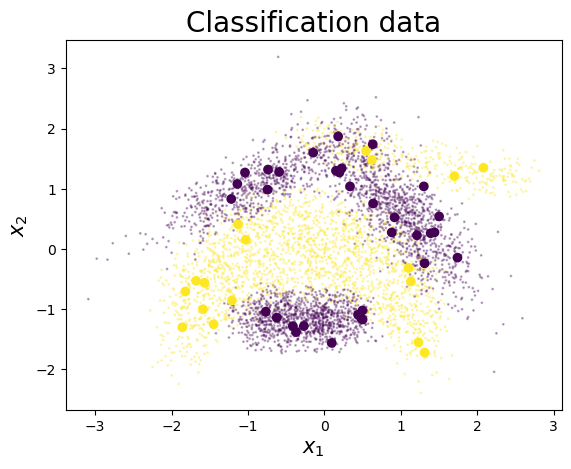

In [169]:
# Loading the data
XY = []
with open("banana.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        XY.append(row)
XY = np.array(XY)

# Here we select a subset of the data. (remember, computation scales as N^3)
np.random.seed(42)
np.random.shuffle(XY)
N = 50
X, Y = XY[:N,:-1], XY[:N,-1:]
Y = (Y-1.5) * 2 # to be in {-1, 1}
N = X.shape[0]

# Plotting the data

plt.scatter(XY[:,0], XY[:,1], c=XY[:,2], s=1, alpha=0.3)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('Classification data', fontsize=20);

**Task 2a**: To fully specify the model, we need the prior covariance $K_p = K_{\bf ff}$ and its Cholesky factor $L_p = chol(K_{\bf ff})$. As usual, the prior mean is zero. Your task here is to implement the standard RBF kernel, parametrized by the length scale $l$ and the kernel variance $\sigma^2$. 

**Note:** The x variables are 2D, meaning that some implementation details are different from the previous assignment.

**Hyperparameter optimization.** Note that in addition to approximating $p(f|y)$, the ELBO can (optionally) be used to optimize the kernel hyperparameters $\{l,\sigma^2\}$ at the same time, because it is a lower bound to the marginal likelihood $p(y)$. To do this, the kernel has to be defined with Tensorflow functions to enable autodifferentiation and calculating gradients for the hyperparameters, which are defined as Tensorflow Variables. In addition, the two hyperparameters need to be parametrized so that they can not get negative values, which is achieved by optimizing their log-values instead (since, e.g., length scale should be in $[0,\infty]$, log length scale is unconstrained in $[-\infty,\infty]$). We will try out optimizing the hyperparameters later on, which is why the implementation below takes the hyperparameters in log-space. 

In [170]:
def create_se_kernel(X1, X2, log_ell, log_sigma_squared):
    """
    Create the kernel matrix using the Squared Exponential kernel.

    Arguments:

    X1    -- NxD matrix.
    X2    -- MxD matrix.
    log_ell -- lengthscale value in log scale. 
    log_sigma_squared -- variance value in log scale. 

    Returns a NxM kernel matrix. 
    """
    # YOUR CODE HERE
    ell = tf.exp(log_ell)
    sigma_squared = tf.exp(log_sigma_squared)
    
    X1_sq = tf.reduce_sum(tf.square(X1), axis=1, keepdims=True)  
    X2_sq = tf.reduce_sum(tf.square(X2), axis=1, keepdims=True)  
    cross_term = tf.matmul(X1, tf.transpose(X2))                 
    dists = X1_sq - 2 * cross_term + tf.transpose(X2_sq)         

    K = sigma_squared * tf.exp(-0.5 * dists / (ell ** 2))
    return K
    #raise NotImplementedError()

### Let's test the above function:

In [171]:
X1 = np.array([[ 1.30, -1.17], [ 0.34, -0.47], [ 0.07, -0.33]])
X2 = np.array([[ 1.28,  1.08], [ 0.44, -1.15], [-0.71, -1.02]])
log_ell_test = np.log(1.5)
log_sigma_squared_test = np.log(2)

assert create_se_kernel(X1, X2, log_ell_test, log_sigma_squared_test).shape == (3, 3)
np.testing.assert_allclose(create_se_kernel(X1, X2, log_ell_test, log_sigma_squared_test), np.array([[0.649, 1.696, 0.810], 
                                                                                           [0.963, 1.800, 1.463], 
                                                                                           [0.928, 1.670 , 1.571]]), atol=1e-3)

### Do not move or delete the below block. It is used for automatic grading.

**Optimizing the ELBO**

Here we initialize the variational distribution to $q({\bf f})={\cal N}({\bf f};0, I)$,
then optimize it to maximize the ELBO using gradient based optimization. Gradient based optimization refers to optimization schemes where a function $f(\theta)$ is optimized with respect to $\theta$ by following the gradient $\nabla_{\theta} f(\theta)$. For example, gradient descent constructs a sequence of values $\theta_t$ following
$$\theta_{t+1 } = \theta_t - \eta \nabla_{\theta} f(\theta)|_{\theta=\theta_t}$$
where $\eta$ is the learning rate. Note that while we want to maximize the ELBO, the standard optimization helpers provided by Tensorflow are designed to minimize functions. Thus, ELBO maximization is implemented as negative ELBO minimization. 

**Note on autodiff.** When using an automatic differentiation framework, one does not need to manually derive the gradient (hence the 'automatic'). As discussed earlier, these frameworks include Tensorflow, Jax and Pytorch.

**Parameterization.** Note that the following code treats the $L_q$ parameters in a special way: Instead of optimizing over all of the $N\times N$ matrix elements, we only optimize over the lower triangular part. In addition, the diagonal elements are constrained to be positive by parameterizing the diagonal in log-space. The reason for this is that Cholesky factors are lower triangular with positive elements on the diagonal, and without forcing these properties, some elements in the upper diagonal could also be optimized to non-zero values or some diagonal elements could become negative. Thus, some of the ELBO calculations would not be quite correct as they assume valid Cholesky factors. This parametrization is achieved by having the $L_q$ lower triangular part in a vector and using a "bijector" from the tensorflow_probability package to transform into a lower triangular matrix in a way that preserves gradients. In addition, and exp transform is applied to the diagonal elements to define the final $L_q$ matrix, forcing positivity. See https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/FillTriangular, https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/TransformDiagonal and https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector if you are interested to learn more.

**Task 2b:** Try to get familiar with the optimization function below and fill out the missing details. Then try running the optimization for $q(\mathbf f)$. At this stage, do not optimize hyperparameters yet. 

In [172]:
def optimize_elbo(ell, sigma_squared, optimize_hyperparams=False, print_progress=True):
    """ Optimize the variational posterior q(f) and (optionally) the length scale and variance hyperparameters.
    
    Arguments:
    ell -- The kernel effective length scale, or its initial value in case optimize_hyperparameters=True
    sigma_squared -- The kernel variance, or its initial value in case optimize_hyperparameters=True
    optimize_hyperparams -- Whether to optimize hyperparameters
    print_progress -- Whether to print out ELBO values during optimization
    
    Returns:
    m_q -- The mean vector of the optimized variational posterior
    L_q -- the Cholesky factor L_q of the covariance of the optimized variational posterior
    elbo_values -- The intermediate values of the ELBO during optimization
    log_ell -- The log effective length scale after optimization
    log_sigma_squared -- The log kernel variance after optimization
    """
    
    # Log-hyperparameters:
    v_log_ell = tf.Variable(np.log(ell), dtype=tf.float64)
    v_log_sigma_squared = tf.Variable(np.log(sigma_squared), dtype=tf.float64)

    # You can change the optimizer or learning rate here
    opt = tf.optimizers.Adam(learning_rate=0.001) 

    num_iterations = 30000 # You can change the number of steps here.
    
    # The prior mean and the Cholesky factor of the prior covariance
    K_p = None  # TASK: Complete this
    m_p = None  # TASK: Complete this
    L_p = None  # TASK: Complete this

    # YOUR CODE HERE

    K_p = create_se_kernel(X, X, v_log_ell, v_log_sigma_squared)
    m_p = tf.zeros((N, 1), dtype=tf.float64)
    L_p = tf.linalg.cholesky(K_p) 
    #raise NotImplementedError()

    assert m_p.dtype == tf.float64
    assert L_p.dtype == tf.float64
    assert K_p.dtype == tf.float64
    
    # Initial distribution parameters m_q, L_q
    m_q = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
    # As Cholesky factors are lower triangular with positive diagonals, we want to parametrize them as such. 
    # Here we use tfp.bijectors.FillTriangular to map the trainable parameters in L_q_params
    # to a lower-triangular matrix and tfp.bijectors.TransformDiagonal to map the diagonals to positive values.
    # L_q is initialized at the identity matrix (note the exp transform for the diagonals)
    # Could also initialize to np.linalg.cholesky(K_p) for potentially faster convergence.
    L_q_params = tf.Variable(tfp.math.fill_triangular_inverse(np.zeros((N,N))), dtype=tf.float64)
    filltriangular = tfp.bijectors.FillTriangular(upper=False)
    positivediagonal = tfp.bijectors.TransformDiagonal(diag_bijector=tfp.bijectors.Exp())
    transform = lambda x: positivediagonal(filltriangular(x))
    
    # Loss function if we don't do hyperparameter optimization
    loss_q = lambda: - elbo(m_p, L_p, m_q, transform(L_q_params), Y)
    # Loss function for hyperparameter optimization (the prior Cholesky factor changes at each step)
    loss_hp = lambda: - elbo(m_p, tf.linalg.cholesky(create_se_kernel(X, X, v_log_ell, v_log_sigma_squared)), m_q, transform(L_q_params), Y)

    # definition of a training step
    def create_train_step(loss, opt, trainable_variables):
        @tf.function  # this makes the optimisation loop much faster, but restricts what operations you can do within your code
        def train_step():
            with tf.GradientTape() as tape:
                tape.watch(trainable_variables)
                loss_value = loss()
            gradients = tape.gradient(loss_value, trainable_variables)
            opt.apply_gradients(zip(gradients, trainable_variables))
            return loss_value
        return train_step

    loss = loss_hp if optimize_hyperparams else loss_q
    trainable_variables = [m_q, L_q_params, v_log_ell, v_log_sigma_squared] if optimize_hyperparams else [m_q, L_q_params]
    train_step = create_train_step(loss, opt, trainable_variables)
    neg_elbo_values = []
    # running the optimization
    for t in range(num_iterations):
        neg_elbo_value = train_step()
        neg_elbo_values.append(neg_elbo_value)
        if t % 5000 == 0 and print_progress:
            print(t, loss().numpy())
    L_q = transform(L_q_params)
    return m_q, L_q, neg_elbo_values, v_log_ell, v_log_sigma_squared

**Run the model.** Next we run the model with the hyperparameters provided.

In [173]:
# The code is complete and just needs to be executed.
if not automatic_grading:
    ell = 0.5  # the length scale
    sigma_squared = 3.0**2  # the kernel variance
    m_q, L_q, neg_elbo_values, log_ell, log_sigma_squared = optimize_elbo(ell, sigma_squared, False)
    print(f"Final Optimized ELBO value: {neg_elbo_values[-1]}")
    assert neg_elbo_values[0] > neg_elbo_values[-1]

0 7319.981994786816
5000 53.01724872135201
10000 23.92436313677282
15000 21.628510738352453
20000 21.61847825402394
25000 21.619104072623237
Final Optimized ELBO value: 21.618640803593696


We also plot the evolution of the ELBO as a function of iterations.

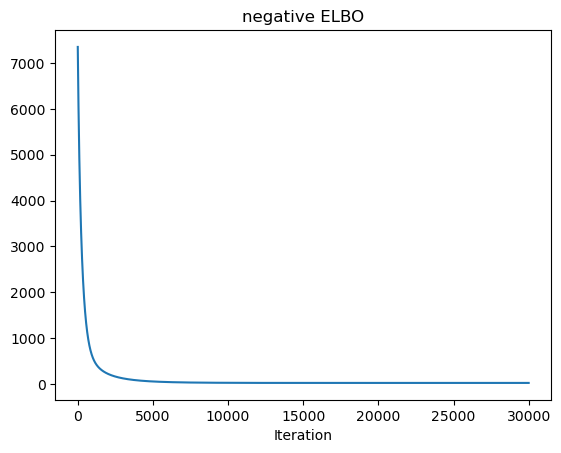

In [174]:
if not automatic_grading:
    plt.plot(neg_elbo_values)
    plt.title("negative ELBO")
    plt.xlabel("Iteration")
    plt.show()

### Task 3: Posterior prediction for new data points (2.5 points)

Under the hood, the algorithm defines a posterior process for all values of the input space.

For a new input $x^*$, the posterior prediction is given by 

$
\begin{align*}
q(f(x^*)) &= \int p(f(x^*)|{\bf f})q({\bf f})d{\bf f}\\
 &= {\cal N}(f(x^*)| K_{f^*{\bf f} }K_{{\bf ff}}^{-1} m_q,
 K_{f^*f^*} - K_{f^*{\bf f}}K_{{\bf ff}}^{-1}(K_{{\bf ff}} - S)K_{{\bf ff}}^{-1}K_{{\bf f} f^*})
\end{align*}
$

where $S$ is the optimized covariance and $\mathbf m_q$ is the optimized mean of $q(\mathbf f)$. Implement this function. 

In [175]:
# create new input points on grid
n_grid = 100
x = np.linspace(XY[:,0].min(), XY[:,1].max(), n_grid)
X1new, X2new = np.meshgrid(x, x)
Xnew = np.hstack([X1new.reshape(-1,1), X2new.reshape(-1,1)])  # size : n_grid * n_grid x 2


**Task 3a:** We should avoid computing the full N_new × N_new covariance matrix $K_{f^{*}f^{*}}$ due to memory limitations. You only need the diagonal values of this matrix for the predictive variances. Implement a function that calculates this. Think of a way of implementing this without using the `create_se_kernel` function.

**Hint:** Notice that we don't need the value of $\ell$ in this function.

**Note:** We only calculate the diagonal kernel matrix for the new points *i.e.* $K_{f^{*}f^{*}}$ as $X^{*}$ are high in number as compared to $X$.

In [176]:
def create_se_kernel_diag(X, log_sigma_squared):
    """
    Create the diagonal of the kernel matrix using the Squared Exponential kernel.

    Arguments:

    X    -- NxD matrix.
    log_sigma_squared -- variance value in log scale. 

    Returns a Nx1 diagonal of the kernel matrix. 
    """
    # YOUR CODE HERE
    sigma_squared = tf.exp(log_sigma_squared)
    N = tf.shape(X)[0]
    return tf.fill([N, 1], sigma_squared)
    #raise NotImplementedError()

#### Let's test the above function

In [177]:
X1 = np.array([[ 1.30, -1.17], [ 0.34, -0.47], [ 0.07, -0.33]])
log_sigma_squared = np.log(2)

assert create_se_kernel_diag(X1, log_sigma_squared).shape == (3, 1)
np.testing.assert_allclose(create_se_kernel_diag(X1, log_sigma_squared), 2 * np.ones((3, 1)), atol=1e-3) 

### Do not move or delete the below block. It is used for automatic grading.

**Task 3b**: Implement the posterior prediction for new points.

In [178]:
def posterior_marginal_prediction(X_new, X, m_q, L_q, log_ell, log_sigma_squared):
    """ compute the posterior marginal predictions q(f(x*)) independently for all inputs in X_new 
    
    Note: You need to use tensorflow functions.
    
    arguments:
    X_new -- N_new × 2, matrix of new inputs
    X     -- N × 2, matrix of training inputs
    m_q   -- N × 1, mean vector of q
    L_q   -- N × N, Cholesky factor of the covariances of q
    log_ell -- log-length-scale of the kernel
    log_sigmasquared -- log-variance of the kernel
    returns: predictive marginal means and variances (both with size N_new × 1)
    """
    # YOUR CODE HERE
    K_XX = create_se_kernel(X, X, log_ell, log_sigma_squared)  
    L_X = tf.linalg.cholesky(K_XX)  
    
    K_star = create_se_kernel(X_new, X, log_ell, log_sigma_squared)  # [N_new x N]
    

    m_new = tf.matmul(K_star, tf.linalg.cholesky_solve(L_X, m_q))
    

    K_star_star_diag = create_se_kernel_diag(X_new, log_sigma_squared) 
    A = tf.linalg.cholesky_solve(L_X, tf.transpose(K_star))
    

    S = tf.matmul(L_q, L_q, transpose_b=True)
    
    B = tf.matmul(K_XX - S, A)
    
    correction = tf.reduce_sum(A * B, axis=0, keepdims=True)  
    correction = tf.transpose(correction)  

    v_new = K_star_star_diag - correction
    #raise NotImplementedError()
    return m_new, v_new
    

#### Let's test the above function

In [179]:
# Test when X_new == X. 

x_test = np.random.randn(5, 1)
m_q_test = np.random.randn(5, 1)
L_q_test = np.random.randn(5, 5)
log_ell_test = np.log(1.2)
log_sigma_squared_test = np.log(0.4)

pred_mean_test, pred_var_test = posterior_marginal_prediction(x_test, x_test, m_q_test, L_q_test, log_ell_test, log_sigma_squared_test)
np.testing.assert_allclose(pred_mean_test, m_q_test)
S_diag_test = np.diag(L_q_test @ np.transpose(L_q_test))[:, None]
np.testing.assert_allclose(pred_var_test, S_diag_test)


### Do not move or delete the below block. It is used for automatic grading.

### For the likelihood
$$ p(y_i|f(\cdot),{\bf x}_i) = p(y_i|f_i) = \phi(y_i * f_i),$$
where $\phi$ is the cdf of the standard normal distribution, the integral $ p(y^*=1 | {\bf y}) \approx \int p(y^*=1 | f^*) q(f^*) \,{\rm d}f^* $
can be solved analytically for Gaussian $q(f^*)$. For $q(f^*) = \mathcal{N}(\mu, \sigma^2)$, we get
$$ \int p(y^* | f^*) q(f^*) \,{\rm d}f^* = \phi(\mu / \sqrt{1 + \sigma^2}) .$$

**Task 3c**: Fill out the implementation of the $y$ output probability given the corresponding GP mean and variance in the function below.

In [180]:
def ynew_probability(m, v):
    """
    return the output probability when the GP mean (m) and variance (v) are given. 
    """
    # YOUR CODE HERE
    denom = tf.sqrt(1.0 + v)
    
    arg = m / denom
    y_new = phi(arg)
    #raise NotImplementedError()
    return y_new
    

#### Let's test the above function

In [181]:
posterior_m_test = np.array([[0.388], [0.351]])
posterior_S_test = np.array([[8.084], [19.940]])

expected_y_prob = np.array([[0.5511], [0.5305]])
y_prob = ynew_probability(posterior_m_test, posterior_S_test)

assert np.allclose(y_prob, expected_y_prob, rtol=1e-4, atol=1e-4)

### Do not move or delete the below block. It is used for automatic grading.

Let us plot the posterior now.

In [182]:
### This function is complete, so nothing needs to be done here.
def plot_posterior(m_new, v_new):
    """
    Plots the posterior prediction for the grid in Xnew (global variable)
    
    arguments:
    m_new -- mean at Xnew
    v_new -- variance at Xnew
    """
    y_new = ynew_probability(m_new, v_new)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.contour(x, x, m_new.numpy().reshape(n_grid,n_grid),
                cmap=plt.cm.RdBu_r, vmin=-np.abs(m_new).max(), vmax=np.abs(m_new).max())
    plt.colorbar()
    plt.title("Posterior mean")
    plt.subplot(1,3,2)
    plt.contour(x, x, v_new.numpy().reshape(n_grid,n_grid))
    plt.colorbar()
    plt.title("Posterior variance")
    plt.subplot(1,3,3)
    plt.contour(x, x, y_new.numpy().reshape(n_grid,n_grid),
                cmap=plt.cm.RdBu_r, vmin=0, vmax=1)
    plt.colorbar()
    plt.title("p(y|f)")
    plt.scatter(X[:,0], X[:,1], c=Y)  # training points

    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())

    plt.scatter(XY[:,0], XY[:,1], c=XY[:,2], s=1, alpha=0.3)  # all data points

    plt.show()


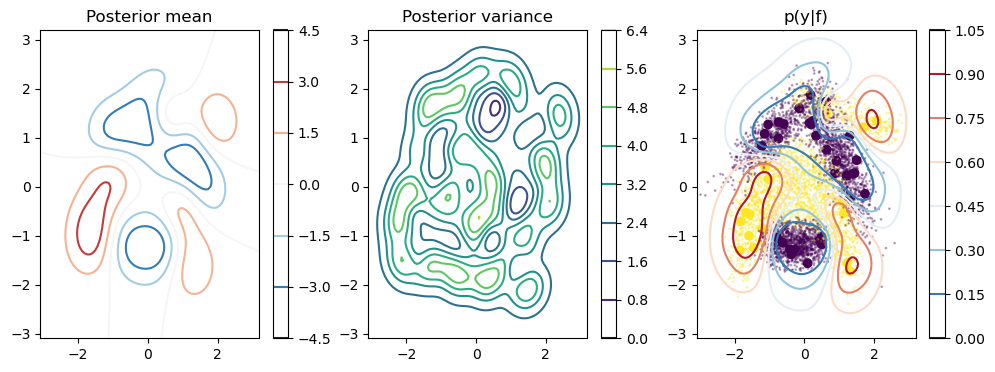

In [183]:
if not automatic_grading:
    m_new, v_new = posterior_marginal_prediction(Xnew, X, m_q, L_q, log_ell, log_sigma_squared)
    plot_posterior(m_new, v_new)

**Task 3d:** Optimize the kernel's hyperparameters, too, by setting `optimize_hyperparameters=True`. Plot the posterior obtained with the optimized hyperparameters. Initialize the hyperparameters with $\ell=0.5$ and $\sigma^2=4$.

0 16299.633608718514
5000 41.555369261168266
10000 26.491213479967428
15000 22.386742443642845
20000 21.40563614724186
25000 21.39272754911697
Final Optimized ELBO value: 21.388052509569594


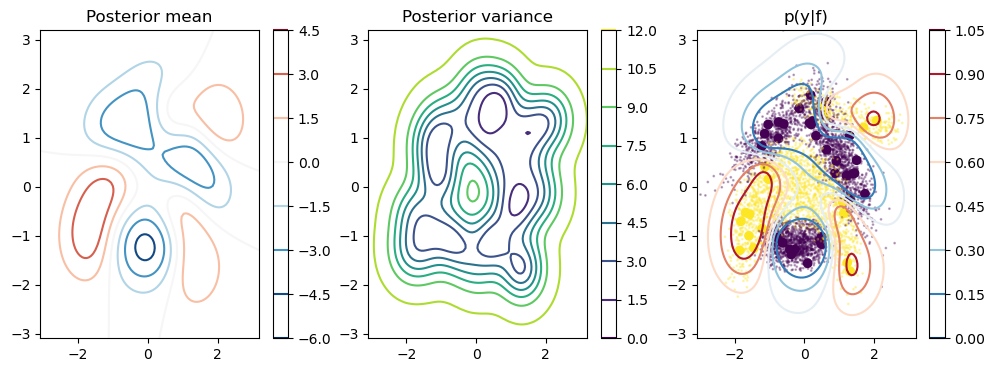

In [186]:
# NOTE: Write your code inside this if condition.
if not automatic_grading:
    # YOUR CODE HERE
    ell = 0.5  # the length scale
    sigma_squared = 4  # the kernel variance
    m_q, L_q, neg_elbo_values, log_ell, log_sigma_squared = optimize_elbo(ell, sigma_squared, True)
    print(f"Final Optimized ELBO value: {neg_elbo_values[-1]}")
    m_new, v_new = posterior_marginal_prediction(Xnew, X, m_q, L_q, log_ell, log_sigma_squared)
    plot_posterior(m_new, v_new)
    #raise NotImplementedError()

**Task 3e:** Does optimizing the hyperparameters give a better ELBO value? Explain!

In [187]:
a_3e = True  # TASK: Replace None with True or False

**Explanation:** {Write your answer here}

The ELBO is a lower bound on the marginal likelihood i.e. it depends on both likelihood and prior. By optimizing the hyperparameters, we optimize the prior beliefs, which in turn aids in optimizing the ELBO value and hence it gives a better ELBO value.

In [ ]:
assert isinstance(a_3e, bool)

### Do not move or delete the below block. It is used for automatic grading.

### Task 4: After answering all the questions, kindly set `automatic_grading=True` at the top of the notebook, use the validate option in the toolbar to validate the notebook and be sure that there are no errors.